# Gradient-Weighted Class Activation Mapping (Grad-CAM) - CIFAR10

In [1]:
import numpy as np
import time
import os

from sklearn.preprocessing import OneHotEncoder
import tensorflow_datasets as tfds
import tensorflow as tf

import warnings
import logging
warnings.filterwarnings("ignore")
tf.get_logger().setLevel(logging.ERROR)

import cv2
from skimage import io
from skimage.transform import resize

from matplotlib import pyplot as plt
%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Initialization

In [2]:
config = {
    'dataset_name': 'cifar10',
    'width': 32,
    'height': 32,
    'num_channels': 3,
    'num_classes': 10,
    'dropout_rate': [0.15, 0.1],
    'learning_rate': 1e-4,
    'model_path': './grad_cam_model.ckpt',
    'log_path': './grad_cam_log.csv'
}

# Data Preparation

In [3]:
def normalize(x):
    # normalize data
    x = x/255.0
    return x.reshape((-1, config['height'], config['width'], config['num_channels']))

In [4]:
def get_one_hot(label):
    # convert label to one-hot encoding
    label = label.reshape(-1, 1)
    encoder = OneHotEncoder(categories = [range(config['num_classes'])])
    encoder.fit(label)
    return encoder.transform(label).toarray()

In [5]:
def get_data(batch_size):
    # get both train and test data
    dataset, info = tfds.load(name = config['dataset_name'], with_info = True)
    labels = info.features['label'].names

    dataset_train_size = info.splits['train'].num_examples
    dataset_test_size = info.splits['test'].num_examples

    dataset_train = dataset['train'].repeat().shuffle(1024).batch(batch_size)
    dataset_test = dataset['test'].repeat().shuffle(1024).batch(batch_size)
    dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)
    dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

    return (dataset_train, dataset_test), (dataset_train_size, dataset_test_size), labels

# Build Model

In [6]:
def model(x, dropout_rate, print_summary = True):
    # build CNN model
    with tf.variable_scope('model_cnn', reuse = False) as scope:
        x_t = tf.transpose(x, [0, 3, 1, 2]) # NHWC to NCHW

        # block 1
        conv1 = tf.layers.conv2d(x_t, 32, [5, 5],
                                 strides = [1, 1],
                                 padding = 'same',
                                 data_format = 'channels_first',
                                 name ='conv1')
        relu1 = tf.nn.relu(conv1, name = 'relu1')
        pool1 = tf.layers.max_pooling2d(relu1, [2, 2],
                                        strides = [2, 2],
                                        padding = 'valid',
                                        data_format = 'channels_first',
                                        name = 'pool1')
        # block 2
        conv2 = tf.layers.conv2d(pool1, 64, [3, 3],
                                 strides = [1, 1],
                                 padding = 'same',
                                 data_format = 'channels_first',
                                 name = 'conv2')
        relu2 = tf.nn.relu(conv2, name = 'relu2')
        pool2 = tf.layers.max_pooling2d(relu2, [2, 2],
                                        strides = [2, 2],
                                        padding = 'valid',
                                        data_format = 'channels_first',
                                        name = 'pool2')
        # block 3
        conv3 = tf.layers.conv2d(pool2, 128, [3, 3],
                                 strides = [1, 1],
                                 padding = 'same',
                                 data_format = 'channels_first',
                                 name = 'conv3')       
        relu3 = tf.nn.relu(conv3, name = 'relu3')
        pool3 = tf.layers.max_pooling2d(relu3, [2, 2],
                                        strides = [2, 2],
                                        padding = 'valid',
                                        data_format = 'channels_first',
                                        name = 'pool3')
        # block 4
        conv4 = tf.layers.conv2d(pool3, 256, [2, 2],
                                 strides = [1, 1],
                                 padding = 'same',
                                 data_format = 'channels_first',
                                 name = 'conv4')
        relu4 = tf.nn.relu(conv4, name = 'relu4')
        pool4  = tf.layers.max_pooling2d(relu4, [2, 2],
                                         strides = [2, 2],
                                         padding = 'valid',
                                         data_format = 'channels_first',
                                         name = 'pool4')
        # block 5
        conv5 = tf.layers.conv2d(pool4, 256, [2, 2],
                                 strides = [1, 1],
                                 padding = 'same',
                                 data_format = 'channels_first',
                                 name = 'conv5')
        relu5 = tf.nn.relu(conv5, name = 'relu5')
        pool5  = tf.layers.max_pooling2d(relu5, [2, 2],
                                         strides = [2, 2],
                                         padding = 'valid',
                                         data_format = 'channels_first',
                                         name = 'pool5')
        dropout5 = tf.layers.dropout(pool5, dropout_rate[0], name = 'dropout5')

        # block 6
        flatten_length = dropout5.get_shape().as_list()[1] * \
                         dropout5.get_shape().as_list()[2] * \
                         dropout5.get_shape().as_list()[3]

        flatten6 = tf.reshape(dropout5, [-1, flatten_length])
        fc6 = tf.layers.dense(flatten6, 512, name = 'fc6')
        relu6 = tf.nn.relu(fc6, name = 'relu6')

        # block 7
        fc7 = tf.layers.dense(relu6, 128, name = 'fc7')
        relu7 = tf.nn.relu(fc7, name = 'relu7')
        dropout7 = tf.layers.dropout(relu7, dropout_rate[1], name = 'dropout7')

        # block 8
        fc8 = tf.layers.dense(dropout7, config['num_classes'], name = 'fc8')
        output = tf.nn.softmax(fc8, name = 'output')
    if print_summary:
        print('model summary:\n ' \
              'Conv1: %s\n Pool1: %s\n Conv2: %s\n Pool2: %s\n' \
              'Conv3: %s\n Pool3: %s\n Conv4: %s\n Pool4: %s\n' \
              'Conv5: %s\n Pool5: %s\n Fc6: %s\n'\
              'Fc7: %s\n Fc8: %s\n' %(conv1.get_shape(), pool1.get_shape(),
                                      conv2.get_shape(), pool2.get_shape(),
                                      conv3.get_shape(), pool3.get_shape(),
                                      conv4.get_shape(), pool4.get_shape(),
                                      conv5.get_shape(), pool5.get_shape(),
                                      fc6.get_shape(), fc7.get_shape(),
                                      fc8.get_shape()))

    return [conv1, conv2, conv3, conv4, conv5], fc8, output

In [7]:
def loss_accuracy(prob, logits, labels):
    # softmax loss and accurary
    with tf.variable_scope('Loss_Acc', reuse = False) as scope:
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,
                                                                      labels = labels))
        correct_pred = tf.equal(tf.argmax(prob, 1), tf.argmax(labels, 1))
        acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        return loss, acc

In [8]:
def optimizer(loss, learning_rate):
    # ADAM optimizer
    with tf.variable_scope('Optimizer', reuse = False) as scope:
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            all_vars = tf.trainable_variables()
            model_vars = [var for var in all_vars if var.name.startswith('model_cnn')]
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,
                                                                       var_list = model_vars)
            return optimizer

In [9]:
def get_placeholders_tensors(target_layer_index = -1):
    # get model's placeholders and tensors
    # target_layer_index is the index of the conv layer
    x = tf.placeholder(tf.float32, name = 'x', shape = [None,
                                                        config['height'],
                                                        config['width'],
                                                        config['num_channels']])
    y = tf.placeholder(tf.float32, name = 'label', shape = [None,
                                                            config['num_classes']])
    dropout_rate = tf.placeholder(tf.float32, name = 'dropout_rate')

    connvs, logits, probs = model(x, dropout_rate, print_summary = True)
    loss, acc  = loss_accuracy(probs, logits, y)

    optim = optimizer(loss, config['learning_rate'])

    grad_cam = Grad_CAM(connvs[target_layer_index], logits, x, y)

    placeholders_tensors = {'x': x,
                            'y': y,
                            'dropout_rate': dropout_rate,
                            'optimizer': optim,
                            'probs': probs,
                            'loss': loss,
                            'acc': acc,
                            'grad_cam': grad_cam}
    return placeholders_tensors

# Grad-CAM and Visualisation

In [10]:
def Grad_CAM(conv_layer, logits, x, y):
    # gradient-weighted activation mapping (Grad_CAM) for visualisation
    with tf.variable_scope('Grad_CAM', reuse = False) as scope:
        y_c = tf.reduce_sum(tf.multiply(logits, y), axis = 1)
        conv_layer_grad = tf.gradients(y_c, conv_layer)[0] # 0: weight, 1: bias
        alpha = tf.reduce_mean(conv_layer_grad, axis = (2, 3)) # feature map importance
        linear_combination = tf.multiply(tf.reshape(alpha, [-1,
                                                            alpha.get_shape().as_list()[1],
                                                            1, 1]), conv_layer)
        grad_cam = tf.nn.relu(tf.reduce_sum(linear_combination, axis = 1))
        return grad_cam

In [11]:
def get_results_for_visualization(sess, placeholders_tensors, dataset, count):
    # get images, grad_cams, and predicated probabilites
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    batch = sess.run(next_element)

    feed_dictionary = {placeholders_tensors['x']: np.array(normalize(batch['image'][:count])),
                       placeholders_tensors['y']: np.array(get_one_hot(batch['label'][:count])),
                       placeholders_tensors['dropout_rate']: [0, 0]}
    probs = sess.run(placeholders_tensors['probs'], feed_dict = feed_dictionary)
    predicted_label = np.argmax(probs, 1)
    feed_dictionary = {placeholders_tensors['x']: np.array(normalize(batch['image'][:count])),
                       placeholders_tensors['y']: np.array(get_one_hot(predicted_label)),
                       placeholders_tensors['dropout_rate']: [0, 0]}
    grad_cam = sess.run(placeholders_tensors['grad_cam'], feed_dict = feed_dictionary)

    return np.array(batch['image']), grad_cam, probs, np.array(batch['label'])

In [12]:
def visualisation(sess, placeholders_tensors, dataset, labels, count):
    # visualise some images and their grad-cam heatmap
    images, grad_cams, probs, ground_truths = get_results_for_visualization(sess,
                                                                            placeholders_tensors,
                                                                            dataset, count)

    _, axes = plt.subplots(figsize = [8, 2 * count], nrows = count,
                           ncols = 4, sharey = True, sharex = True)

    for idx in list(range(count)):
        grad_cam = grad_cams[idx] / np.max(grad_cams[idx]) # normalize
        grad_cam = resize(grad_cam, (config['height'], config['width']),
                          preserve_range = True, mode = 'constant')
        grad_cam_heatmap = cv2.applyColorMap(np.uint8(255.0 * grad_cam), cv2.COLORMAP_JET)
        grad_cam_heatmap = cv2.cvtColor(grad_cam_heatmap, cv2.COLOR_BGR2RGB)

        image = normalize(images[idx]).reshape(config['height'],
                                               config['width'],
                                               config['num_channels'])
        max_prob_idx = np.argmax(probs[idx])
        ground_truth = ground_truths[idx]
        pred_Truth_labels = labels[max_prob_idx] + " / " + labels[ground_truth]

        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title('Input Image')
        axes[idx, 0].axis('off')
        axes[idx, 1].imshow(grad_cam_heatmap)
        axes[idx, 1].set_title('Grad_CAM')
        axes[idx, 1].axis('off')
        axes[idx, 2].imshow(image)
        axes[idx, 2].imshow(grad_cam_heatmap, alpha = 0.5)
        axes[idx, 2].set_title('Overlayed')
        axes[idx, 2].axis('off')
        axes[idx, 3].imshow(np.ones_like(image), alpha = 0.0)
        axes[idx, 3].text(5, 16, pred_Truth_labels, color = 'white', fontsize = 15)
        axes[idx, 3].set_title('Prediction / GroundTruth')
        axes[idx, 3].axis('off')
    plt.tight_layout()
    plt.show()

# Train Model

In [13]:
def save_model_on_imporvemnet(file_path, sess, cv_acc, cv_accs):
  #  save model when there is improvemnet in cv_acc value
    if cv_accs == [] or cv_acc > np.max(cv_accs):
        saver = tf.train.Saver(max_to_keep = 1)
        saver.save(sess, file_path)
        print('Model saved')
        return True
    print('')
    return False

In [14]:
def log_loss_acc(file_path, epoch, train_loss, train_acc,
                 cv_loss, cv_acc, log_mode = 'a'):
    # log train and cv losses as well as accuracy
    mode = log_mode if epoch == 0 else 'a'

    with open(file_path, mode) as f:
        if mode == 'w':
            header = 'epoch, train_loss, train_acc, cv_loss, cv_acc\n'
            f.write(header)

        line = '%d, %f, %f, %f, %f\n' %(epoch, train_loss, train_acc, cv_loss, cv_acc)
        f.write(line)

In [15]:
def train_per_epoch(sess, dataset, placeholders_tensors, epoch, train_batches_count):
    # one epoch of training
    # loss and accuracy are returned
    tmp_loss, tmp_acc = [], []
    t_total = 0

    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    for iteration in range(train_batches_count):
        t_start = time.time()
        batch = sess.run(next_element)
        feed_dictionary = {placeholders_tensors['x']: np.array(normalize(batch['image'])),
                           placeholders_tensors['y']: np.array(get_one_hot(batch['label'])),
                           placeholders_tensors['dropout_rate']: config['dropout_rate']}

        sess.run(placeholders_tensors['optimizer'], feed_dict = feed_dictionary)
        train_loss = sess.run(placeholders_tensors['loss'], feed_dict = feed_dictionary)
        train_acc = sess.run(placeholders_tensors['acc'], feed_dict = feed_dictionary)
        tmp_loss.append(train_loss)
        tmp_acc.append(train_acc)
        t_total += (time.time() - t_start)
        print(' '*60, end = '\r')
        print('epoch: %d, time: %f | train_loss: %f | acc: %f' %(epoch, t_total, train_loss,
                                                                 train_acc), end = '\r')
    train_loss = np.mean(tmp_loss)
    train_acc = np.mean(tmp_acc)
    print(' '*60, end = '\r')
    print('epoch: %d, time: %f | train_loss: %f | acc: %f\n' %(epoch, t_total, train_loss,
                                                               train_acc), end = '\r')
    return train_loss, train_acc

In [16]:
def cv_per_epoch(sess, dataset, placeholders_tensors, epoch, cv_batches_count):
    # cross-validation per epoch
    # cv_loss and cv_accuracy are returned
    tmp_loss, tmp_acc = [], []
    t_total = 0

    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    for iteration in range(cv_batches_count):
        t_start = time.time()
        batch = sess.run(next_element)
        cv_feed_dictionary = {placeholders_tensors['x']: np.array(normalize(batch['image'])),
                              placeholders_tensors['y']: np.array(get_one_hot(batch['label'])),
                              placeholders_tensors['dropout_rate']: [0, 0]}

        cv_loss = sess.run(placeholders_tensors['loss'], feed_dict = cv_feed_dictionary)
        cv_acc = sess.run(placeholders_tensors['acc'], feed_dict = cv_feed_dictionary)

        tmp_loss.append(cv_loss)
        tmp_acc.append(cv_acc)
        t_total += (time.time() - t_start)
        print(' '*60, end = '\r')
        print('          cv_time: %f | cv_loss: %f | cv_acc: %f' %(t_total, cv_loss,
                                                                   cv_acc), end = '\r')
    cv_loss = np.mean(tmp_loss)
    cv_acc = np.mean(tmp_acc)
    print(' '*60, end = '\r')
    print('          cv_time: %f | cv_loss: %f | cv_acc: %f\n' %(t_total, cv_loss,
                                                                 cv_acc), end = '\r')
    return cv_loss, cv_acc

In [17]:
def train_model(batch_size, epochs, resume, conv_layer_vis_index = -1):
    # train CNN model
    init_epoch = 0
    train_losses, cv_losses = [], []
    train_accs, cv_accs = [], []
    tf.reset_default_graph()
    placeholders_tensors = get_placeholders_tensors(target_layer_index = conv_layer_vis_index)

    with tf.Session() as sess:
        if resume:
            print('loading weights....')
            saver = tf.train.Saver()
            saver.restore(sess, (config['model_path']))  # to load the best saved model
            # load saved losses and accuracies so that less accurate model
            # won't be saved after resume
            tmp = np.genfromtxt(config['log_path'], delimiter = ',', names = True)
            train_losses = list(tmp['train_loss'])
            train_accs = list(tmp['train_acc'])
            cv_losses = list(tmp['cv_loss'])
            cv_accs = list(tmp['cv_acc'])
            init_epoch  = len(train_losses)
            del tmp
        else:
            print('initializing weights....')
            init_op = tf.group(tf.local_variables_initializer(), tf.global_variables_initializer())
            sess.run(init_op)

        print('training....')
        dataset, dataset_count, labels = get_data(batch_size)
        train_batch_count = int(dataset_count[0] / batch_size) + 1
        cv_batch_count = int(dataset_count[1] / batch_size) + 1
        for epoch in range(init_epoch, init_epoch + epochs):
            # training
            train_loss, train_acc = train_per_epoch(sess, dataset[0],
                                                    placeholders_tensors, epoch, train_batch_count)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # cross-validation
            cv_loss, cv_acc = cv_per_epoch(sess, dataset[1],
                                           placeholders_tensors, epoch, cv_batch_count)
            # save model
            is_saved = save_model_on_imporvemnet(config['model_path'], sess, cv_acc, cv_accs)
            cv_losses.append(cv_loss)
            cv_accs.append(cv_acc)
            # log results
            log_loss_acc(config['log_path'], epoch, train_loss, train_acc, cv_loss, cv_acc,
                         log_mode = ('a' if resume else 'w'))
            # visualization
            if is_saved:
                visualisation(sess, placeholders_tensors, dataset[1], labels, 4)
        return train_losses, cv_losses, train_accs, cv_accs

model summary:
 Conv1: (?, 32, 32, 32)
 Pool1: (?, 32, 16, 16)
 Conv2: (?, 64, 16, 16)
 Pool2: (?, 64, 8, 8)
Conv3: (?, 128, 8, 8)
 Pool3: (?, 128, 4, 4)
 Conv4: (?, 256, 4, 4)
 Pool4: (?, 256, 2, 2)
Conv5: (?, 256, 2, 2)
 Pool5: (?, 256, 1, 1)
 Fc6: (?, 512)
Fc7: (?, 128)
 Fc8: (?, 10)

initializing weights....
training....


W0919 16:15:31.398048 181064 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


epoch: 0, time: 14.002771 | train_loss: 1.958674 | acc: 0.290019
          cv_time: 2.175719 | cv_loss: 1.792127 | cv_acc: 0.353516
Model saved


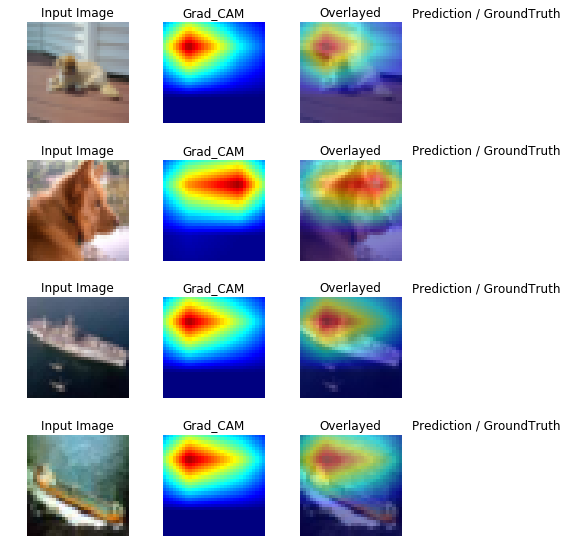

epoch: 1, time: 10.895579 | train_loss: 1.660874 | acc: 0.396664
          cv_time: 2.189714 | cv_loss: 1.607883 | cv_acc: 0.401953
Model saved


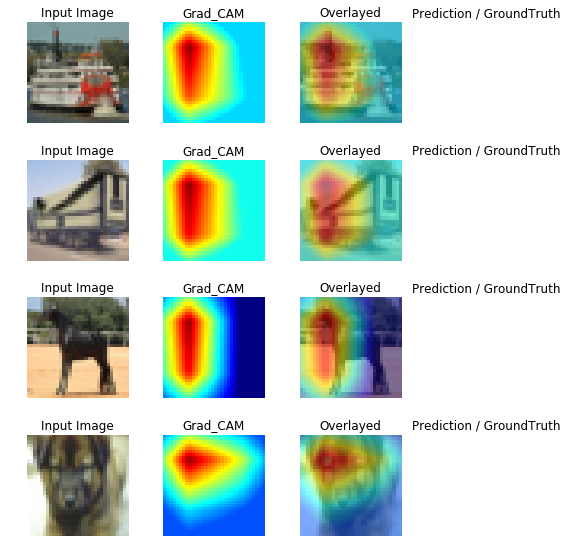

epoch: 2, time: 10.590756 | train_loss: 1.544183 | acc: 0.435108
          cv_time: 2.114759 | cv_loss: 1.504256 | cv_acc: 0.446289
Model saved


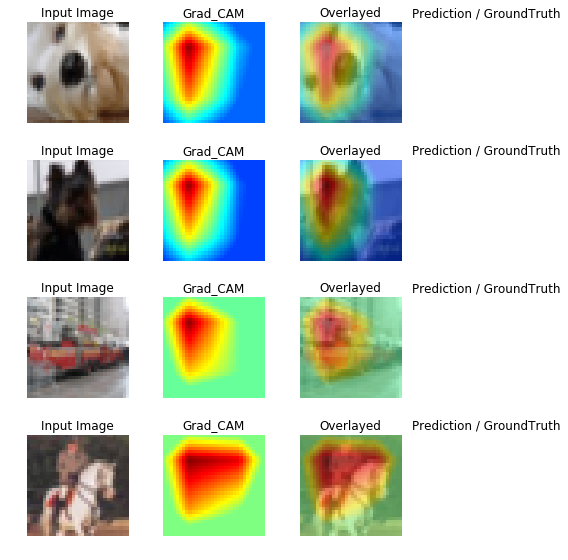

epoch: 3, time: 11.265356 | train_loss: 1.460887 | acc: 0.466139
          cv_time: 2.210713 | cv_loss: 1.428511 | cv_acc: 0.478223
Model saved


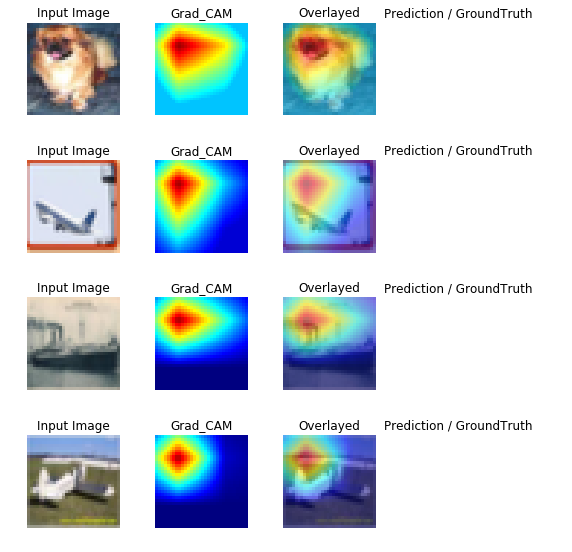

epoch: 4, time: 10.612746 | train_loss: 1.399199 | acc: 0.489816
          cv_time: 2.153729 | cv_loss: 1.397237 | cv_acc: 0.489844
Model saved


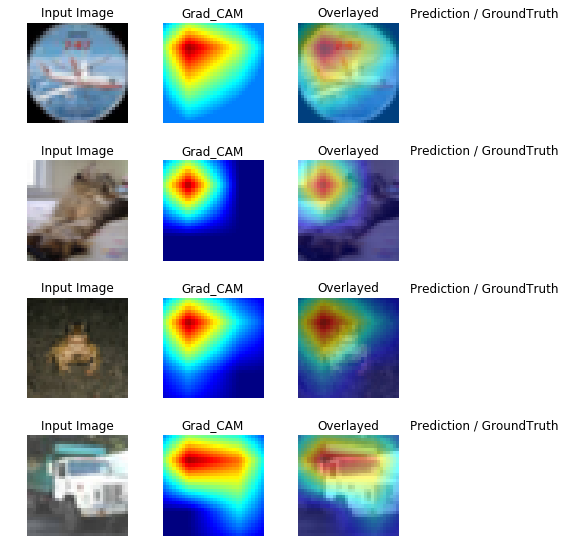

epoch: 5, time: 11.501454 | train_loss: 1.349170 | acc: 0.511918
          cv_time: 2.322174 | cv_loss: 1.333827 | cv_acc: 0.513086
Model saved


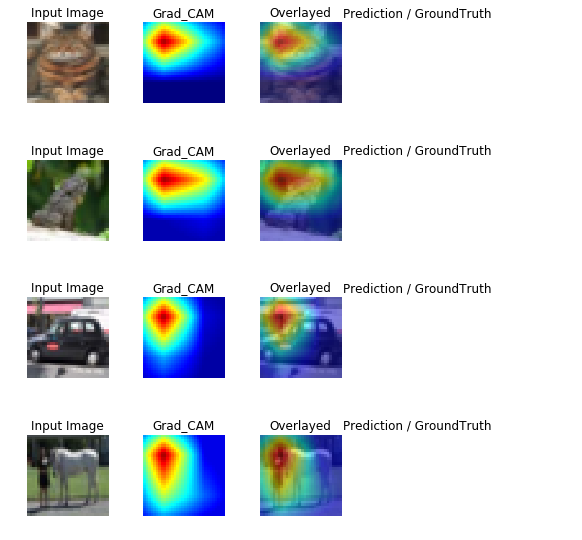

epoch: 6, time: 11.743145 | train_loss: 1.297874 | acc: 0.532326
          cv_time: 2.124746 | cv_loss: 1.262107 | cv_acc: 0.542871
Model saved


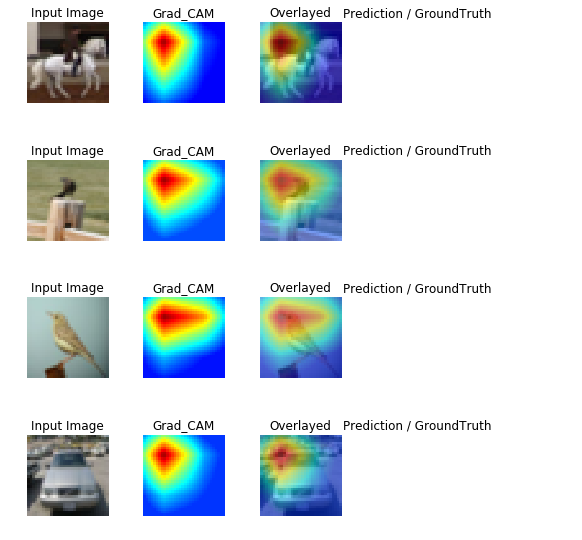

epoch: 7, time: 11.048462 | train_loss: 1.258994 | acc: 0.546875
          cv_time: 2.175718 | cv_loss: 1.268505 | cv_acc: 0.546973
Model saved


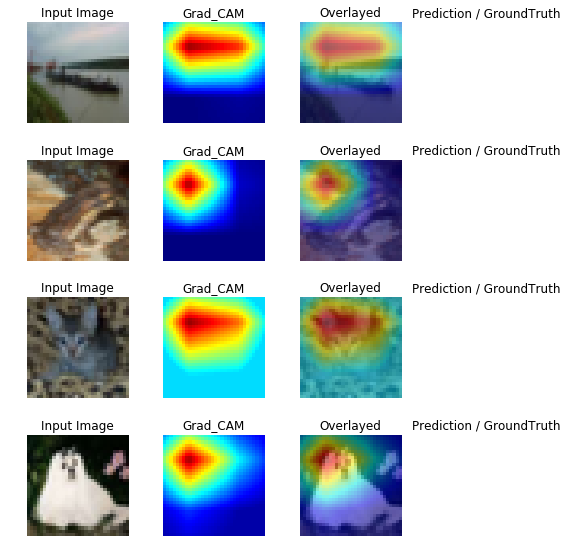

epoch: 8, time: 10.443813 | train_loss: 1.228399 | acc: 0.559849
          cv_time: 2.181719 | cv_loss: 1.230336 | cv_acc: 0.552637
Model saved


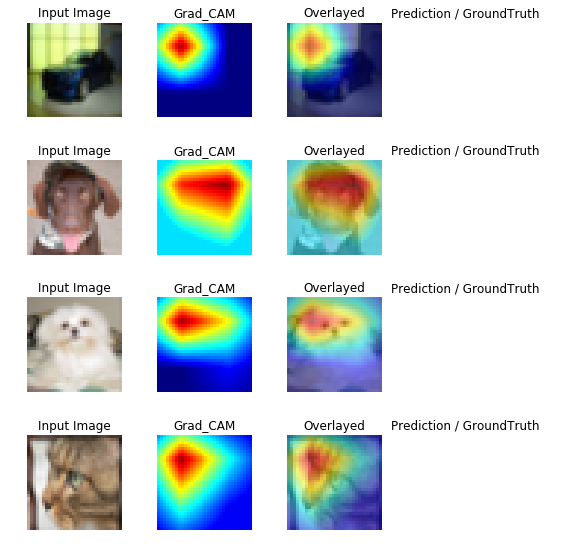

epoch: 9, time: 10.585646 | train_loss: 1.202800 | acc: 0.566526
          cv_time: 2.182712 | cv_loss: 1.207825 | cv_acc: 0.566504
Model saved


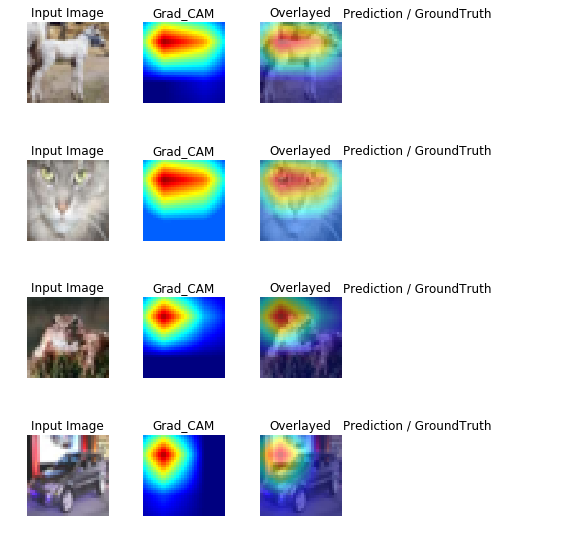

epoch: 10, time: 10.855568 | train_loss: 1.172363 | acc: 0.579998
          cv_time: 2.170723 | cv_loss: 1.182018 | cv_acc: 0.570801
Model saved


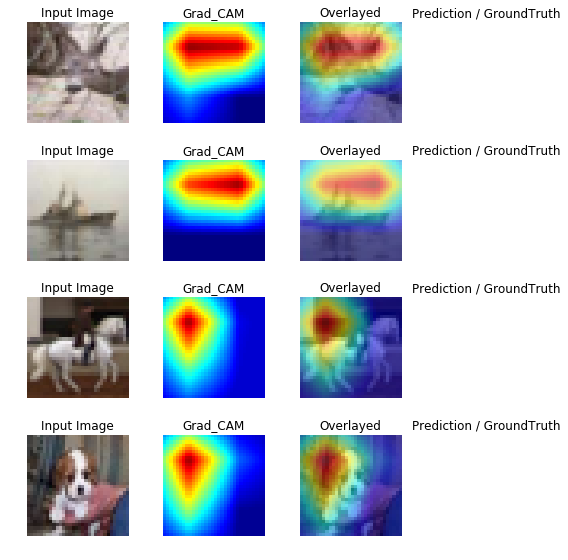

epoch: 11, time: 11.094453 | train_loss: 1.141424 | acc: 0.591558
          cv_time: 2.191722 | cv_loss: 1.143397 | cv_acc: 0.590723
Model saved


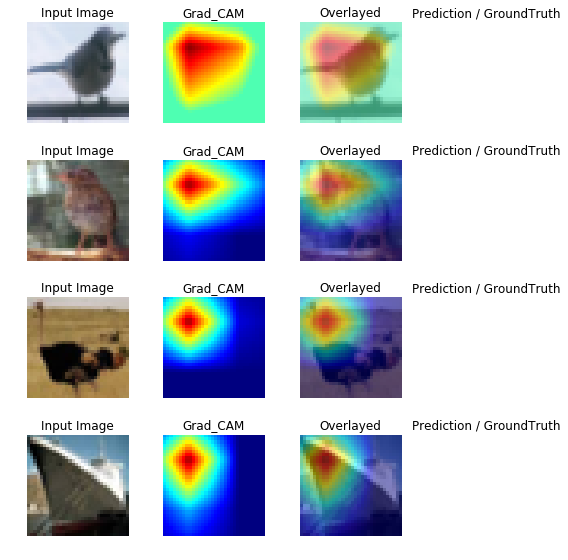

epoch: 12, time: 10.400826 | train_loss: 1.123744 | acc: 0.598852
          cv_time: 2.158736 | cv_loss: 1.165647 | cv_acc: 0.582812

epoch: 13, time: 10.959500 | train_loss: 1.100681 | acc: 0.606545
          cv_time: 2.664430 | cv_loss: 1.167051 | cv_acc: 0.580371

epoch: 14, time: 10.597723 | train_loss: 1.076609 | acc: 0.616271
          cv_time: 2.639438 | cv_loss: 1.104628 | cv_acc: 0.607031
Model saved


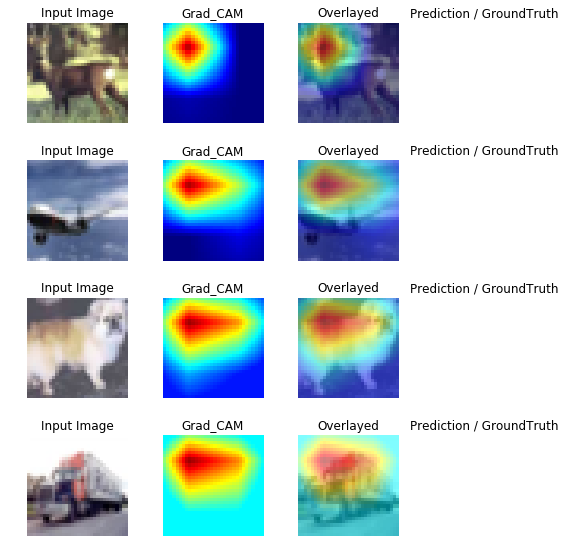

epoch: 15, time: 10.987504 | train_loss: 1.049595 | acc: 0.626834
          cv_time: 2.209700 | cv_loss: 1.102058 | cv_acc: 0.605371

epoch: 16, time: 10.818600 | train_loss: 1.032892 | acc: 0.632653
          cv_time: 2.169719 | cv_loss: 1.085839 | cv_acc: 0.614355
Model saved


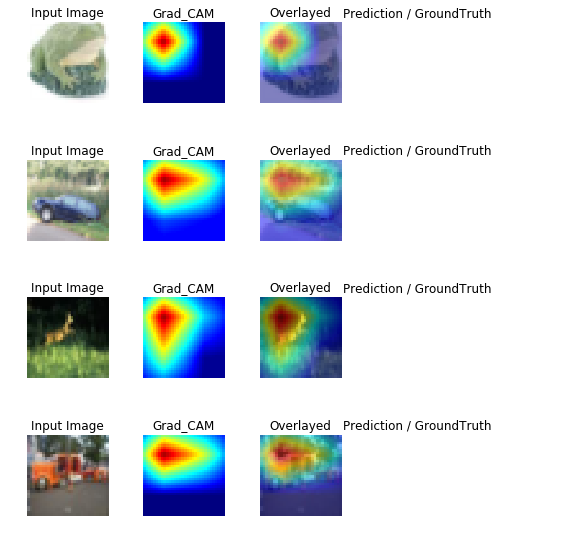

epoch: 17, time: 11.825956 | train_loss: 1.012224 | acc: 0.639589
          cv_time: 2.250669 | cv_loss: 1.063690 | cv_acc: 0.621875
Model saved


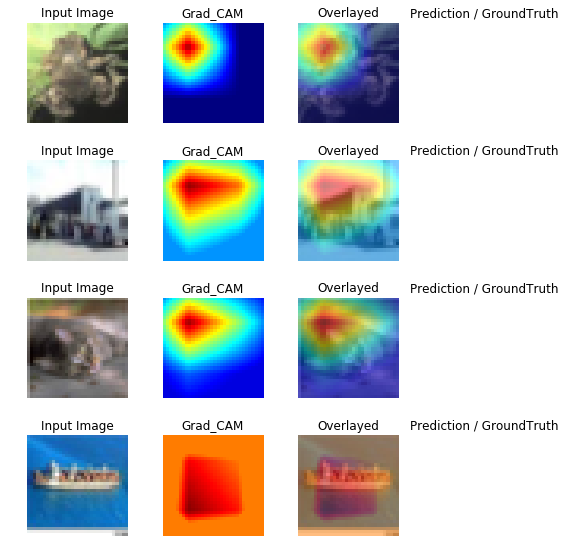

epoch: 18, time: 10.463793 | train_loss: 0.988655 | acc: 0.652005
          cv_time: 2.232681 | cv_loss: 1.065292 | cv_acc: 0.620117

epoch: 19, time: 11.798022 | train_loss: 0.978560 | acc: 0.652922
          cv_time: 2.251678 | cv_loss: 1.075342 | cv_acc: 0.614453

epoch: 20, time: 12.097850 | train_loss: 0.954154 | acc: 0.663006
          cv_time: 2.245670 | cv_loss: 1.037368 | cv_acc: 0.630176
Model saved


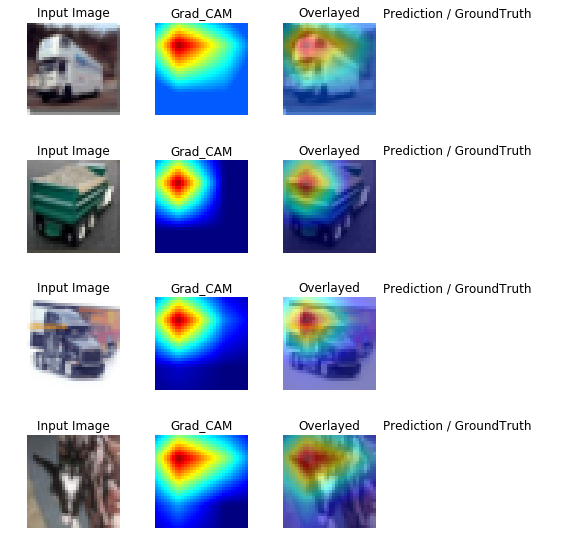

epoch: 21, time: 11.625106 | train_loss: 0.934551 | acc: 0.670141
          cv_time: 2.429564 | cv_loss: 1.030933 | cv_acc: 0.639844
Model saved


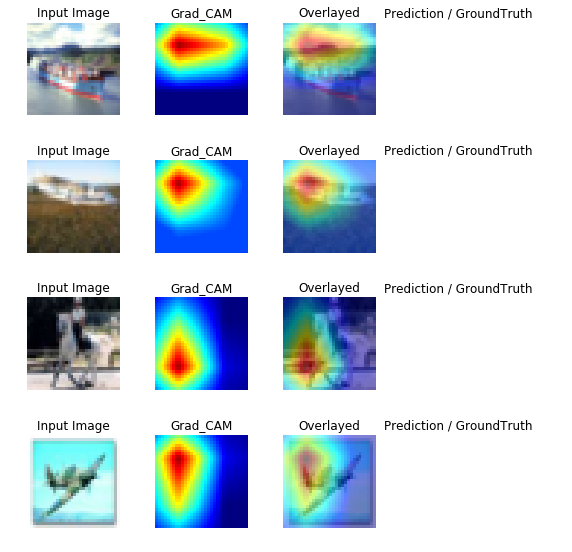

epoch: 22, time: 10.902530 | train_loss: 0.919982 | acc: 0.674107
          cv_time: 2.237668 | cv_loss: 1.036277 | cv_acc: 0.634570

epoch: 23, time: 11.485209 | train_loss: 0.901605 | acc: 0.682717
          cv_time: 2.720386 | cv_loss: 1.025317 | cv_acc: 0.638965

epoch: 24, time: 11.878963 | train_loss: 0.886730 | acc: 0.688895
          cv_time: 2.266652 | cv_loss: 0.992399 | cv_acc: 0.649805
Model saved


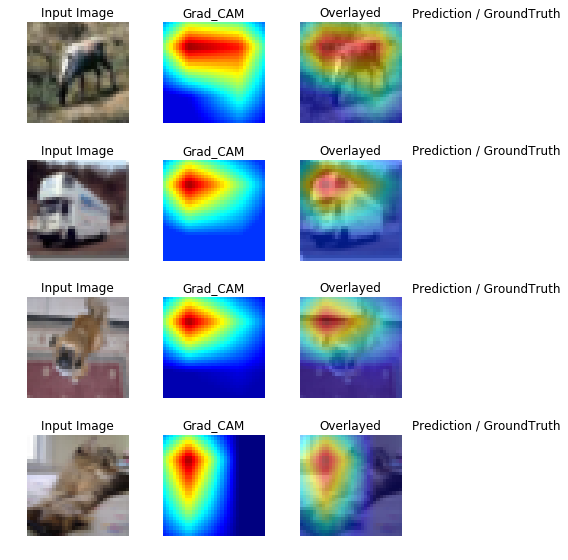

epoch: 25, time: 12.076861 | train_loss: 0.866369 | acc: 0.694974
          cv_time: 2.357609 | cv_loss: 1.020727 | cv_acc: 0.639844

epoch: 26, time: 11.934908 | train_loss: 0.858768 | acc: 0.698382
          cv_time: 2.282650 | cv_loss: 1.002685 | cv_acc: 0.649707

epoch: 27, time: 11.365276 | train_loss: 0.848471 | acc: 0.701052
          cv_time: 2.282650 | cv_loss: 1.010147 | cv_acc: 0.641895

epoch: 28, time: 10.797586 | train_loss: 0.823889 | acc: 0.711416
          cv_time: 2.263676 | cv_loss: 0.983169 | cv_acc: 0.655371
Model saved


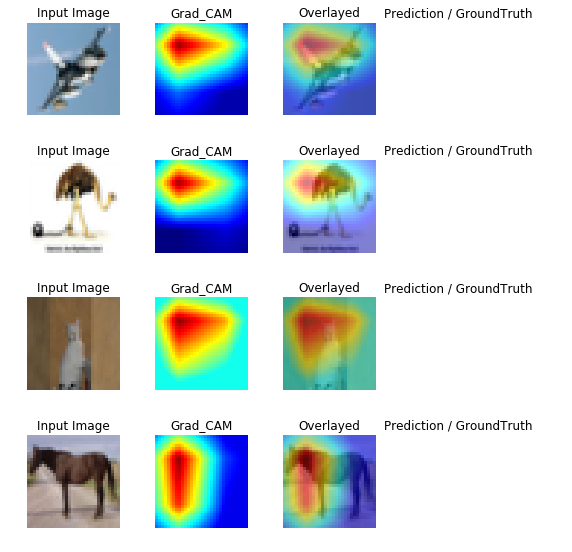

epoch: 29, time: 11.223344 | train_loss: 0.809575 | acc: 0.715163
          cv_time: 2.261660 | cv_loss: 0.978817 | cv_acc: 0.661133
Model saved


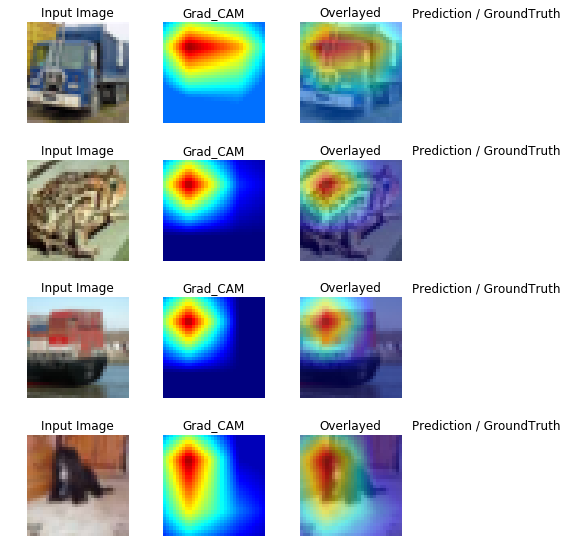

epoch: 30, time: 10.751605 | train_loss: 0.795057 | acc: 0.723135
          cv_time: 2.233680 | cv_loss: 0.991896 | cv_acc: 0.654492

epoch: 31, time: 11.477206 | train_loss: 0.783217 | acc: 0.725785
          cv_time: 2.437563 | cv_loss: 0.945810 | cv_acc: 0.669727
Model saved


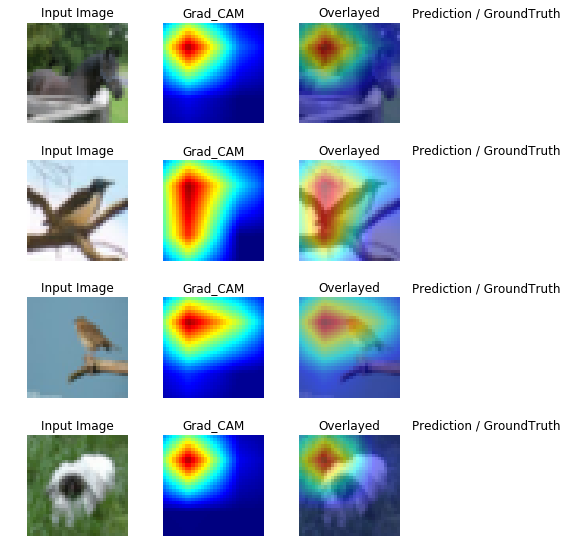

epoch: 32, time: 12.172780 | train_loss: 0.775025 | acc: 0.728615
          cv_time: 2.222684 | cv_loss: 0.957808 | cv_acc: 0.668652

epoch: 33, time: 12.223780 | train_loss: 0.752400 | acc: 0.737922
          cv_time: 2.445559 | cv_loss: 0.993483 | cv_acc: 0.653320

epoch: 34, time: 10.878551 | train_loss: 0.747057 | acc: 0.738680
          cv_time: 2.756375 | cv_loss: 0.959292 | cv_acc: 0.666797

epoch: 35, time: 12.198787 | train_loss: 0.730554 | acc: 0.745655
          cv_time: 2.276657 | cv_loss: 0.966807 | cv_acc: 0.666602

epoch: 36, time: 11.802026 | train_loss: 0.712017 | acc: 0.752571
          cv_time: 2.238681 | cv_loss: 0.954997 | cv_acc: 0.668555

epoch: 37, time: 11.520184 | train_loss: 0.703174 | acc: 0.755839
          cv_time: 2.766368 | cv_loss: 0.935245 | cv_acc: 0.678027
Model saved


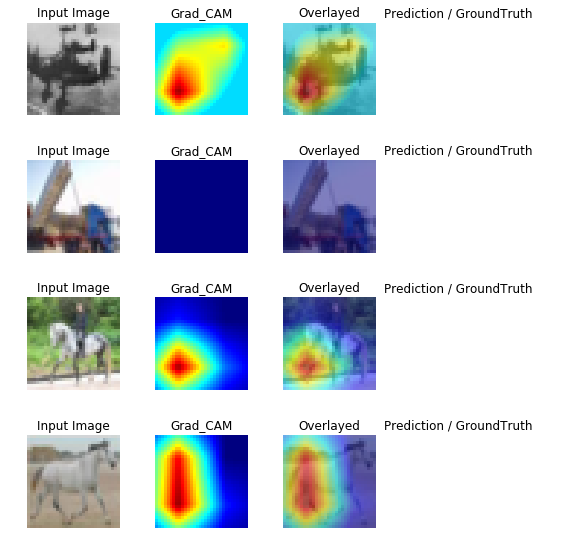

epoch: 38, time: 10.494763 | train_loss: 0.691492 | acc: 0.760623
          cv_time: 2.735382 | cv_loss: 0.927879 | cv_acc: 0.683203
Model saved


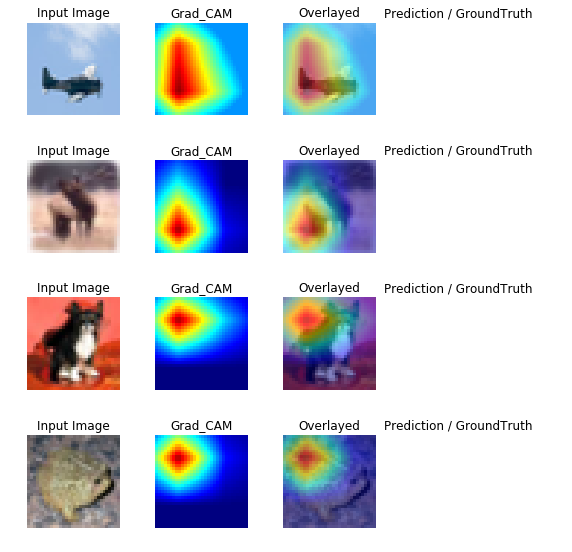

epoch: 39, time: 10.975511 | train_loss: 0.688826 | acc: 0.761519
          cv_time: 2.185705 | cv_loss: 0.942683 | cv_acc: 0.681738

epoch: 40, time: 10.885545 | train_loss: 0.662796 | acc: 0.771066
          cv_time: 2.213696 | cv_loss: 0.953292 | cv_acc: 0.675586

epoch: 41, time: 10.397830 | train_loss: 0.657102 | acc: 0.774275
          cv_time: 2.686415 | cv_loss: 0.941215 | cv_acc: 0.679395

epoch: 42, time: 11.113438 | train_loss: 0.643659 | acc: 0.777782
          cv_time: 2.247672 | cv_loss: 0.958276 | cv_acc: 0.676270

epoch: 43, time: 10.672666 | train_loss: 0.633028 | acc: 0.782844
          cv_time: 2.237679 | cv_loss: 0.934477 | cv_acc: 0.685449
Model saved


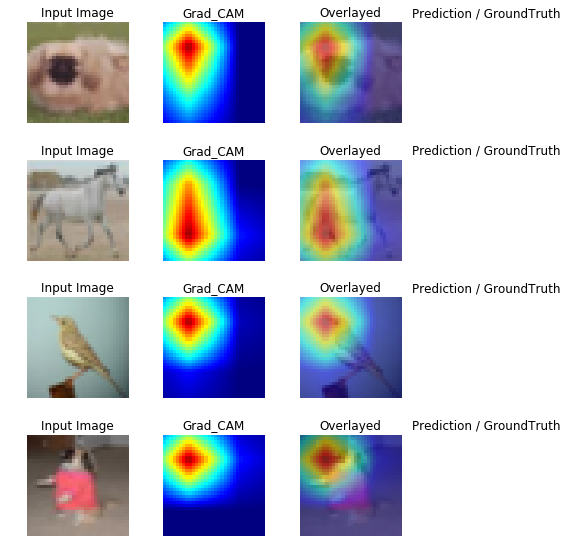

epoch: 44, time: 10.744643 | train_loss: 0.621166 | acc: 0.783901
          cv_time: 2.302642 | cv_loss: 0.916927 | cv_acc: 0.688867
Model saved


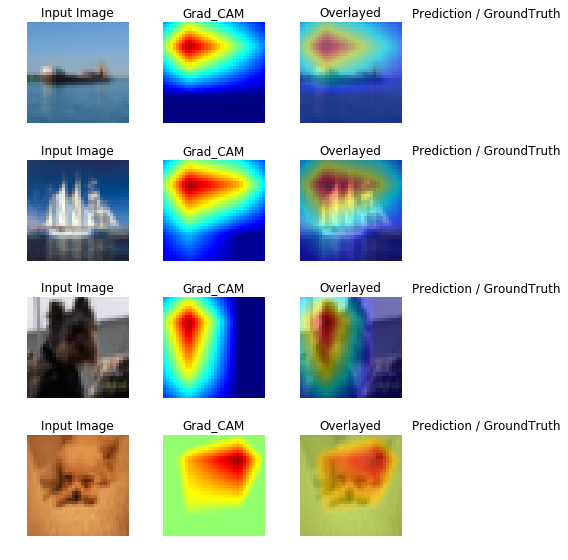

epoch: 45, time: 10.549726 | train_loss: 0.607254 | acc: 0.791374
          cv_time: 2.597470 | cv_loss: 0.973940 | cv_acc: 0.679395

epoch: 46, time: 11.187383 | train_loss: 0.600682 | acc: 0.791912
          cv_time: 2.551493 | cv_loss: 0.926376 | cv_acc: 0.689062
Model saved


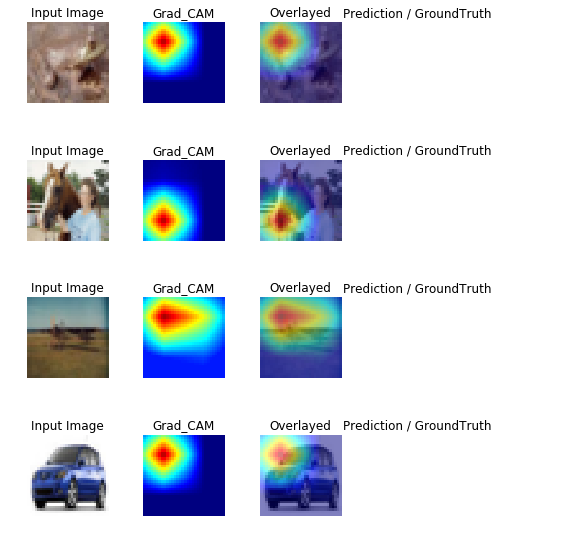

epoch: 47, time: 11.623369 | train_loss: 0.588383 | acc: 0.798091
          cv_time: 2.666425 | cv_loss: 0.952374 | cv_acc: 0.684180

epoch: 48, time: 10.759627 | train_loss: 0.574796 | acc: 0.802356
          cv_time: 2.214698 | cv_loss: 0.948060 | cv_acc: 0.682227

epoch: 49, time: 11.621135 | train_loss: 0.562349 | acc: 0.807518
          cv_time: 2.186729 | cv_loss: 0.953730 | cv_acc: 0.680371

epoch: 50, time: 10.937526 | train_loss: 0.552071 | acc: 0.812062
          cv_time: 2.241678 | cv_loss: 0.950542 | cv_acc: 0.684473

epoch: 51, time: 11.089432 | train_loss: 0.539413 | acc: 0.818260
          cv_time: 2.525504 | cv_loss: 0.931053 | cv_acc: 0.690918
Model saved


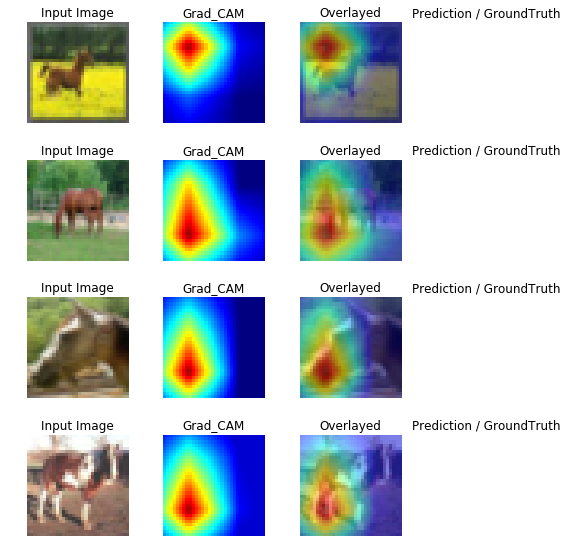

epoch: 52, time: 10.939533 | train_loss: 0.527472 | acc: 0.820332
          cv_time: 2.241677 | cv_loss: 0.963783 | cv_acc: 0.687695

epoch: 53, time: 10.244943 | train_loss: 0.515057 | acc: 0.826909
          cv_time: 2.162720 | cv_loss: 0.958041 | cv_acc: 0.685059

epoch: 54, time: 11.099427 | train_loss: 0.514158 | acc: 0.824717
          cv_time: 2.254677 | cv_loss: 0.999900 | cv_acc: 0.673633

epoch: 55, time: 10.098018 | train_loss: 0.500084 | acc: 0.832151
          cv_time: 2.175715 | cv_loss: 0.930656 | cv_acc: 0.694629
Model saved


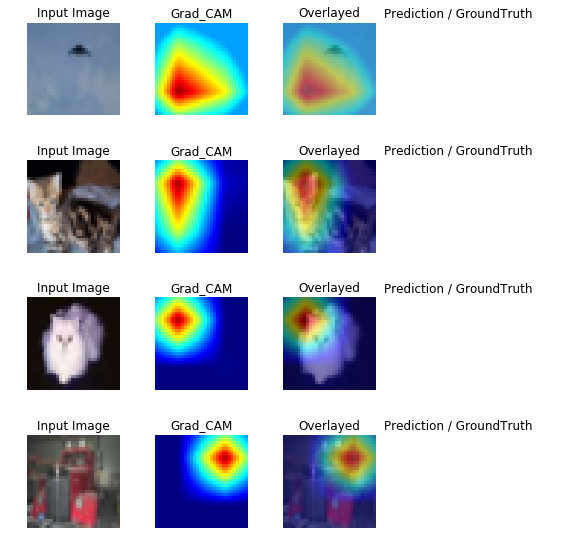

epoch: 56, time: 11.764041 | train_loss: 0.483320 | acc: 0.836376
          cv_time: 2.261665 | cv_loss: 1.008296 | cv_acc: 0.674121

epoch: 57, time: 10.945558 | train_loss: 0.475068 | acc: 0.839644
          cv_time: 2.179719 | cv_loss: 0.965343 | cv_acc: 0.692285

epoch: 58, time: 11.022499 | train_loss: 0.463053 | acc: 0.844946
          cv_time: 2.729394 | cv_loss: 0.971671 | cv_acc: 0.687305

epoch: 59, time: 10.610729 | train_loss: 0.455193 | acc: 0.846799
          cv_time: 2.186714 | cv_loss: 0.983180 | cv_acc: 0.686328

epoch: 60, time: 11.338322 | train_loss: 0.439597 | acc: 0.852938
          cv_time: 2.293648 | cv_loss: 0.969738 | cv_acc: 0.689062

epoch: 61, time: 10.415850 | train_loss: 0.430079 | acc: 0.857900
          cv_time: 2.198712 | cv_loss: 1.004293 | cv_acc: 0.687988

epoch: 62, time: 10.756663 | train_loss: 0.426988 | acc: 0.856704
          cv_time: 2.251676 | cv_loss: 1.005191 | cv_acc: 0.686328

epoch: 63, time: 10.608727 | train_loss: 0.414666 | acc: 0.859

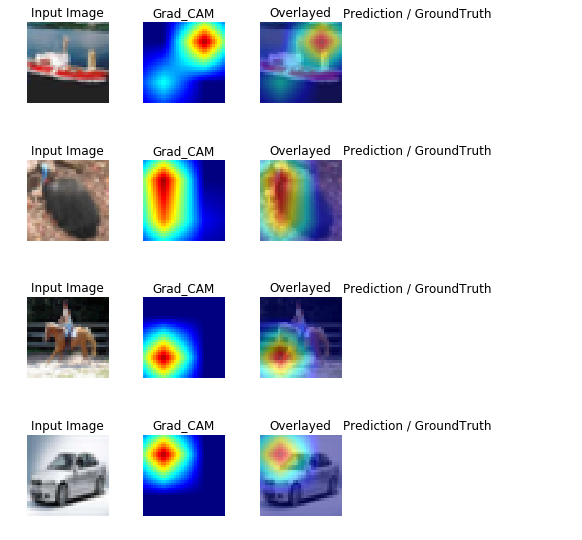

epoch: 76, time: 10.156997 | train_loss: 0.279516 | acc: 0.912189
          cv_time: 2.246682 | cv_loss: 1.171784 | cv_acc: 0.676855

epoch: 77, time: 10.337897 | train_loss: 0.267273 | acc: 0.917451
          cv_time: 2.228705 | cv_loss: 1.135660 | cv_acc: 0.687695

epoch: 78, time: 10.794610 | train_loss: 0.261719 | acc: 0.917690
          cv_time: 2.194674 | cv_loss: 1.157836 | cv_acc: 0.690137

epoch: 79, time: 10.339849 | train_loss: 0.251117 | acc: 0.922054
          cv_time: 2.194700 | cv_loss: 1.181576 | cv_acc: 0.686914

epoch: 80, time: 11.305297 | train_loss: 0.247793 | acc: 0.921935
          cv_time: 2.241675 | cv_loss: 1.235172 | cv_acc: 0.681055

epoch: 81, time: 11.399247 | train_loss: 0.232130 | acc: 0.929528
          cv_time: 2.635438 | cv_loss: 1.226313 | cv_acc: 0.684766

epoch: 82, time: 11.157391 | train_loss: 0.225341 | acc: 0.931780
          cv_time: 2.269659 | cv_loss: 1.218793 | cv_acc: 0.688086

epoch: 83, time: 11.010468 | train_loss: 0.216734 | acc: 0.934

epoch: 197, time: 10.952535 | train_loss: 0.000675 | acc: 1.000000
          cv_time: 2.283654 | cv_loss: 2.982881 | cv_acc: 0.691406

epoch: 198, time: 11.895982 | train_loss: 0.000765 | acc: 1.000000
          cv_time: 2.722398 | cv_loss: 2.994856 | cv_acc: 0.692578

epoch: 199, time: 11.254335 | train_loss: 0.695626 | acc: 0.851762
          cv_time: 2.261667 | cv_loss: 1.247357 | cv_acc: 0.671875

epoch: 200, time: 10.961515 | train_loss: 0.106316 | acc: 0.967953
          cv_time: 2.332629 | cv_loss: 1.978141 | cv_acc: 0.691309

epoch: 201, time: 16.272408 | train_loss: 0.014384 | acc: 0.999243
          cv_time: 2.739384 | cv_loss: 2.227400 | cv_acc: 0.691992

epoch: 202, time: 11.521198 | train_loss: 0.005559 | acc: 1.000000
          cv_time: 2.348617 | cv_loss: 2.339091 | cv_acc: 0.694434

epoch: 203, time: 12.726995 | train_loss: 0.003513 | acc: 1.000000
          cv_time: 2.966256 | cv_loss: 2.429286 | cv_acc: 0.693750

epoch: 204, time: 11.858997 | train_loss: 0.002671 | ac

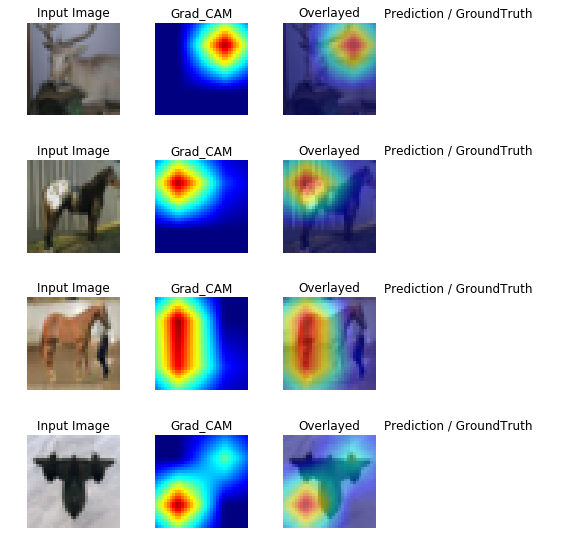

epoch: 205, time: 11.529204 | train_loss: 0.002171 | acc: 1.000000
          cv_time: 2.791352 | cv_loss: 2.533798 | cv_acc: 0.697168
Model saved


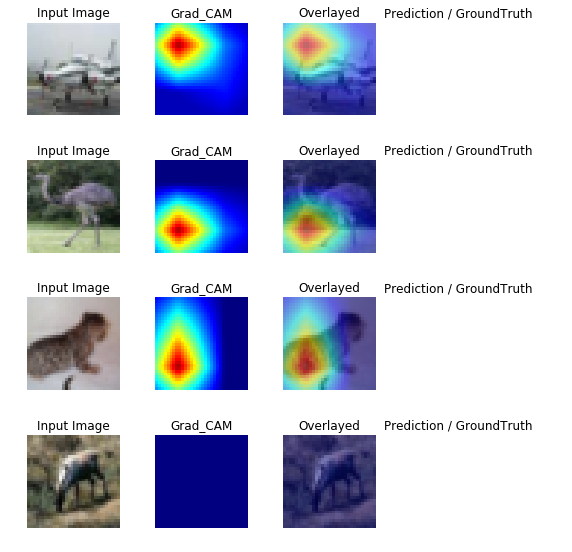

epoch: 206, time: 11.912785 | train_loss: 0.001870 | acc: 1.000000
          cv_time: 2.897831 | cv_loss: 2.605746 | cv_acc: 0.693652

epoch: 207, time: 13.457725 | train_loss: 0.001598 | acc: 1.000000
          cv_time: 2.269660 | cv_loss: 2.633303 | cv_acc: 0.696191

epoch: 208, time: 11.369286 | train_loss: 0.001411 | acc: 1.000000
          cv_time: 2.764364 | cv_loss: 2.667525 | cv_acc: 0.696094

epoch: 209, time: 10.910545 | train_loss: 0.001249 | acc: 1.000000
          cv_time: 2.306638 | cv_loss: 2.705276 | cv_acc: 0.693359

epoch: 210, time: 11.135437 | train_loss: 0.001111 | acc: 1.000000
          cv_time: 2.329624 | cv_loss: 2.757542 | cv_acc: 0.694629

epoch: 211, time: 11.818017 | train_loss: 0.001002 | acc: 1.000000
          cv_time: 2.306634 | cv_loss: 2.801148 | cv_acc: 0.695898

epoch: 212, time: 12.422675 | train_loss: 0.000910 | acc: 1.000000
          cv_time: 2.309646 | cv_loss: 2.809606 | cv_acc: 0.692773

epoch: 213, time: 10.760626 | train_loss: 0.000813 | ac

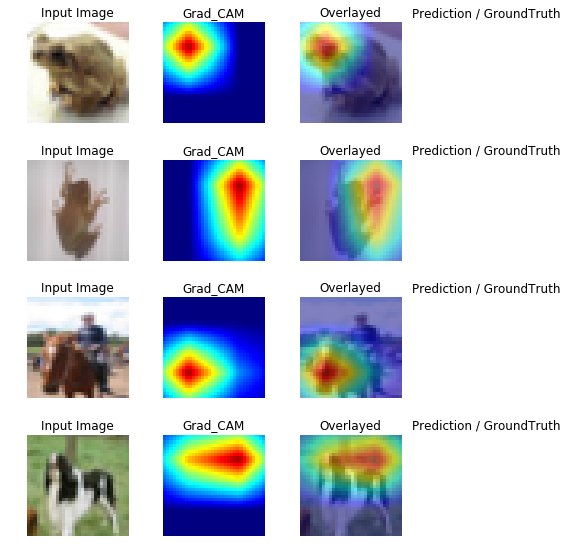

epoch: 214, time: 11.230383 | train_loss: 0.000751 | acc: 1.000000
          cv_time: 2.313640 | cv_loss: 2.857094 | cv_acc: 0.694824

epoch: 215, time: 11.207433 | train_loss: 0.000678 | acc: 1.000000
          cv_time: 2.226687 | cv_loss: 2.919546 | cv_acc: 0.693359

epoch: 216, time: 11.137425 | train_loss: 0.290238 | acc: 0.936264
          cv_time: 2.913282 | cv_loss: 1.892322 | cv_acc: 0.675879

epoch: 217, time: 12.212801 | train_loss: 0.031998 | acc: 0.993343
          cv_time: 2.837331 | cv_loss: 2.244611 | cv_acc: 0.689453

epoch: 218, time: 11.470217 | train_loss: 0.005676 | acc: 0.999980
          cv_time: 2.358599 | cv_loss: 2.359708 | cv_acc: 0.694238

epoch: 219, time: 10.976494 | train_loss: 0.003049 | acc: 1.000000
          cv_time: 2.407579 | cv_loss: 2.411911 | cv_acc: 0.694922

epoch: 220, time: 11.409257 | train_loss: 0.002326 | acc: 1.000000
          cv_time: 2.341617 | cv_loss: 2.485115 | cv_acc: 0.695703

epoch: 221, time: 10.962518 | train_loss: 0.001900 | ac

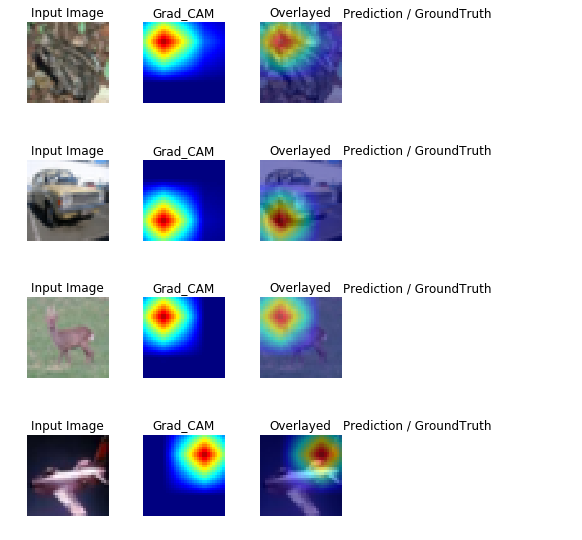

epoch: 245, time: 11.754038 | train_loss: 0.000751 | acc: 1.000000
          cv_time: 2.501514 | cv_loss: 2.808907 | cv_acc: 0.696289

epoch: 246, time: 11.531160 | train_loss: 0.000679 | acc: 1.000000
          cv_time: 2.424572 | cv_loss: 2.825216 | cv_acc: 0.695508

epoch: 247, time: 11.700054 | train_loss: 0.000616 | acc: 1.000000
          cv_time: 2.784362 | cv_loss: 2.874733 | cv_acc: 0.696875

epoch: 248, time: 11.456184 | train_loss: 0.000552 | acc: 1.000000
          cv_time: 2.476542 | cv_loss: 2.898027 | cv_acc: 0.695898

epoch: 249, time: 11.619083 | train_loss: 0.000506 | acc: 1.000000
          cv_time: 2.700397 | cv_loss: 2.927635 | cv_acc: 0.696875

epoch: 250, time: 11.425197 | train_loss: 0.000457 | acc: 1.000000
          cv_time: 2.490520 | cv_loss: 2.967266 | cv_acc: 0.693652

epoch: 251, time: 11.354253 | train_loss: 0.000423 | acc: 1.000000
          cv_time: 2.745375 | cv_loss: 3.004026 | cv_acc: 0.696289

epoch: 252, time: 11.600103 | train_loss: 0.000388 | ac

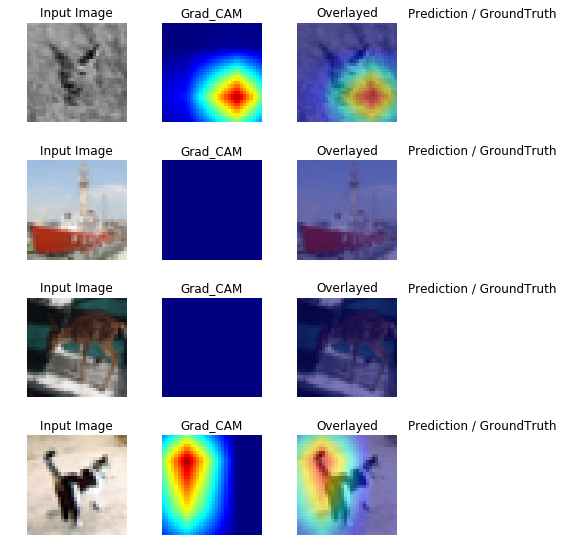

epoch: 268, time: 11.994952 | train_loss: 0.001064 | acc: 1.000000
          cv_time: 2.258675 | cv_loss: 2.693836 | cv_acc: 0.698535

epoch: 269, time: 10.831596 | train_loss: 0.000908 | acc: 1.000000
          cv_time: 2.267669 | cv_loss: 2.733805 | cv_acc: 0.700098

epoch: 270, time: 11.288343 | train_loss: 0.000785 | acc: 1.000000
          cv_time: 2.217700 | cv_loss: 2.806090 | cv_acc: 0.698730

epoch: 271, time: 11.281343 | train_loss: 0.000697 | acc: 1.000000
          cv_time: 2.266668 | cv_loss: 2.838789 | cv_acc: 0.698145

epoch: 272, time: 10.806653 | train_loss: 0.000618 | acc: 1.000000
          cv_time: 2.367609 | cv_loss: 2.855927 | cv_acc: 0.699414

epoch: 273, time: 11.304302 | train_loss: 0.000555 | acc: 1.000000
          cv_time: 2.316638 | cv_loss: 2.889971 | cv_acc: 0.698242

epoch: 274, time: 11.175412 | train_loss: 0.000504 | acc: 1.000000
          cv_time: 2.259674 | cv_loss: 2.897870 | cv_acc: 0.700293

epoch: 275, time: 10.922569 | train_loss: 0.000455 | ac

In [18]:
loss_acc = train_model(256, 300, False, -1)